# Numpy scaffolds

# Část 1: Načtení a základní analýza FASTA dat
# Úkol 1.1: Načtení FASTA souboru

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def read_fasta(filename):
    """
    Načte FASTA soubor a vrátí slovník scaffoldů.
    Formát: {scaffold_id: sequence}
    """
    scaffolds = {}
    current_id = None
    current_seq = []
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_id is not None:
                    scaffolds[current_id] = ''.join(current_seq)
                current_id = line[1:].split()[0]
                current_seq = []
            else:
                current_seq.append(line)
        
        if current_id is not None:
            scaffolds[current_id] = ''.join(current_seq)
    
    return scaffolds

# Simulace dat pro cvičení
def generate_test_data():
    """Vygeneruje testovací genomová data hlavonožce"""
    np.random.seed(42)
    
    # Báze DNA
    bases = ['A', 'C', 'G', 'T']
    
    # Vytvoření 10 scaffoldů různých délek
    scaffolds = {}
    for i in range(1, 11):
        scaffold_len = np.random.randint(10000, 500000)
        # Realističtější distribuce bází s GC biasem hlavonožců (~40% GC)
        p = [0.3, 0.2, 0.2, 0.3]  # A, C, G, T
        sequence = np.random.choice(bases, size=scaffold_len, p=p)
        scaffolds[f'scaffold_{i}'] = ''.join(sequence)
    
    return scaffolds

# Test
scaffolds = generate_test_data()
print(f"Počet scaffoldů: {len(scaffolds)}")
for scaffold_id, seq in list(scaffolds.items())[:3]:
    print(f"{scaffold_id}: délka {len(seq)} bp")

Počet scaffoldů: 10
scaffold_1: délka 131958 bp
scaffold_2: délka 197275 bp
scaffold_3: délka 255793 bp


# Úkol 1.2: Základní statistika scaffoldů

In [2]:
def calculate_scaffold_stats(scaffolds):
    """
    Vypočítá základní statistiku scaffoldů.
    """
    lengths = np.array([len(seq) for seq in scaffolds.values()])
    
    stats = {
        'total_scaffolds': len(lengths),
        'total_bp': np.sum(lengths),
        'mean_length': np.mean(lengths),
        'median_length': np.median(lengths),
        'std_length': np.std(lengths),
        'min_length': np.min(lengths),
        'max_length': np.max(lengths),
        'N50': calculate_N50(lengths),
        'N90': calculate_N90(lengths)
    }
    
    return stats, lengths

def calculate_N50(lengths):
    """Vypočítá N50 hodnotu"""
    sorted_lengths = np.sort(lengths)[::-1]
    cumulative_sum = np.cumsum(sorted_lengths)
    total = np.sum(lengths)
    half_total = total / 2
    
    # Najdi první scaffold kde kumulativní suma překročí polovinu
    mask = cumulative_sum >= half_total
    if np.any(mask):
        return sorted_lengths[np.argmax(mask)]
    return 0

def calculate_N90(lengths):
    """Vypočítá N90 hodnotu"""
    sorted_lengths = np.sort(lengths)[::-1]
    cumulative_sum = np.cumsum(sorted_lengths)
    total = np.sum(lengths)
    target = total * 0.9
    
    mask = cumulative_sum >= target
    if np.any(mask):
        return sorted_lengths[np.argmax(mask)]
    return 0

# Výpočet statistik
stats, lengths = calculate_scaffold_stats(scaffolds)
print("\n=== Základní statistika scaffoldů ===")
for key, value in stats.items():
    print(f"{key}: {value:,.0f}" if isinstance(value, (int, float)) else f"{key}: {value}")


=== Základní statistika scaffoldů ===
total_scaffolds: 10
total_bp: 2601726
mean_length: 260,173
median_length: 226,534
std_length: 127,260
min_length: 118126
max_length: 481696
N50: 308102
N90: 133529


# Část 2: Analýza sekvenčního složení
# Úkol 2.1: GC obsah a bias

In [3]:
def calculate_gc_content(sequence):
    """
    Vypočítá GC obsah sekvence.
    """
    sequence = sequence.upper()
    g_count = sequence.count('G')
    c_count = sequence.count('C')
    total = len(sequence)
    
    return (g_count + c_count) / total if total > 0 else 0

def analyze_base_composition(scaffolds, window_size=1000):
    """
    Analyzuje složení bází v oknech po genome.
    """
    gc_contents = []
    at_skews = []
    gc_skews = []
    
    for scaffold_id, seq in scaffolds.items():
        seq_len = len(seq)
        
        # Analyzuj v oknech
        for start in range(0, seq_len, window_size):
            end = min(start + window_size, seq_len)
            window = seq[start:end].upper()
            
            if len(window) == 0:
                continue
            
            # Počty bází
            a = window.count('A')
            c = window.count('C')
            g = window.count('G')
            t = window.count('T')
            total = a + c + g + t
            
            if total > 0:
                # GC obsah
                gc = (g + c) / total
                gc_contents.append(gc)
                
                # AT skew = (A - T) / (A + T)
                if a + t > 0:
                    at_skew = (a - t) / (a + t)
                    at_skews.append(at_skew)
                
                # GC skew = (G - C) / (G + C)
                if g + c > 0:
                    gc_skew = (g - c) / (g + c)
                    gc_skews.append(gc_skew)
    
    return {
        'gc_contents': np.array(gc_contents),
        'at_skews': np.array(at_skews),
        'gc_skews': np.array(gc_skews)
    }

# Analýza
composition = analyze_base_composition(scaffolds)

print("\n=== Analýza sekvenčního složení ===")
print(f"Průměrný GC obsah: {np.mean(composition['gc_contents']):.3%}")
print(f"Medián GC: {np.median(composition['gc_contents']):.3%}")
print(f"AT skew: μ={np.mean(composition['at_skews']):.3f}, σ={np.std(composition['at_skews']):.3f}")
print(f"GC skew: μ={np.mean(composition['gc_skews']):.3f}, σ={np.std(composition['gc_skews']):.3f}")


=== Analýza sekvenčního složení ===
Průměrný GC obsah: 39.999%
Medián GC: 40.000%
AT skew: μ=-0.000, σ=0.041
GC skew: μ=-0.001, σ=0.050


# Úkol 2.2: Hledání kódovacích oblastí (CDS)

In [4]:
def find_orf(sequence, min_length=100):
    """
    Hledá otevřené čtecí rámy (ORFs) v DNA sekvenci.
    """
    # Genetický kód (standardní)
    start_codon = 'ATG'
    stop_codons = ['TAA', 'TAG', 'TGA']
    
    orfs = []
    seq_len = len(sequence)
    
    # Pro všechny tři čtecí rámy
    for frame in range(3):
        in_orf = False
        orf_start = 0
        
        for pos in range(frame, seq_len - 2, 3):
            codon = sequence[pos:pos+3].upper()
            
            if not in_orf and codon == start_codon:
                in_orf = True
                orf_start = pos
            elif in_orf and codon in stop_codons:
                orf_end = pos + 3
                orf_length = orf_end - orf_start
                
                if orf_length >= min_length:
                    orfs.append({
                        'start': orf_start,
                        'end': orf_end,
                        'length': orf_length,
                        'frame': frame + 1,
                        'sequence': sequence[orf_start:orf_end]
                    })
                
                in_orf = False
    
    return orfs

def codon_usage(sequence):
    """
    Analyzuje užití kodonů v sekvenci.
    """
    codon_table = defaultdict(int)
    seq_len = len(sequence)
    
    # Počítání kodonů v rámci 0
    for pos in range(0, seq_len - 2, 3):
        codon = sequence[pos:pos+3].upper()
        if len(codon) == 3:
            codon_table[codon] += 1
    
    # Normalizace na relativní frekvence
    total_codons = sum(codon_table.values())
    codon_freq = {codon: count/total_codons 
                  for codon, count in codon_table.items()} if total_codons > 0 else {}
    
    return codon_freq

# Analýza ORFů v jednom scaffoldu
test_scaffold = list(scaffolds.values())[0]
orfs = find_orf(test_scaffold, min_length=300)

print(f"\n=== Nalezené ORFy v scaffold_1 ===")
print(f"Počet ORFů (>300bp): {len(orfs)}")
if orfs:
    lengths = np.array([orf['length'] for orf in orfs])
    print(f"Délky ORFů: min={lengths.min()}, max={lengths.max()}, mean={lengths.mean():.0f}")


=== Nalezené ORFy v scaffold_1 ===
Počet ORFů (>300bp): 4
Délky ORFů: min=342, max=381, mean=365


# Část 3: Srovnávací analýza s jinými organismy
# Úkol 3.1: Dinukleotidové frekvence

In [5]:
def calculate_dinucleotide_frequencies(sequence):
    """
    Vypočítá relativní frekvence dinukleotidů.
    """
    bases = ['A', 'C', 'G', 'T']
    dinucleotides = [b1 + b2 for b1 in bases for b2 in bases]
    
    counts = {dinuc: 0 for dinuc in dinucleotides}
    seq_upper = sequence.upper()
    
    for i in range(len(seq_upper) - 1):
        dinuc = seq_upper[i:i+2]
        if dinuc in counts:
            counts[dinuc] += 1
    
    # Normalizace
    total = sum(counts.values())
    frequencies = {dinuc: count/total for dinuc, count in counts.items()} if total > 0 else counts
    
    return frequencies

def compare_with_reference(cephalopod_seq, reference_org='human'):
    """
    Porovná dinukleotidové frekvence s referenčním organismem.
    """
    # Referenční frekvence (příklad - reálná data by byla načtena)
    reference_freq = {
        'human': {
            'AA': 0.146, 'AC': 0.076, 'AG': 0.090, 'AT': 0.130,
            'CA': 0.095, 'CC': 0.055, 'CG': 0.018, 'CT': 0.089,
            'GA': 0.088, 'GC': 0.058, 'GG': 0.055, 'GT': 0.077,
            'TA': 0.133, 'TC': 0.088, 'TG': 0.095, 'TT': 0.147
        },
        'drosophila': {
            'AA': 0.122, 'AC': 0.087, 'AG': 0.094, 'AT': 0.097,
            'CA': 0.094, 'CC': 0.067, 'CG': 0.025, 'CT': 0.087,
            'GA': 0.087, 'GC': 0.067, 'GG': 0.067, 'GT': 0.094,
            'TA': 0.097, 'TC': 0.087, 'TG': 0.094, 'TT': 0.122
        },
        'e_coli': {
            'AA': 0.154, 'AC': 0.067, 'AG': 0.070, 'AT': 0.089,
            'CA': 0.083, 'CC': 0.052, 'CG': 0.038, 'CT': 0.066,
            'GA': 0.066, 'GC': 0.052, 'GG': 0.052, 'GT': 0.083,
            'TA': 0.089, 'TC': 0.067, 'TG': 0.070, 'TT': 0.154
        }
    }
    
    # Vypočítat frekvence pro hlavonožce
    cephalopod_freq = calculate_dinucleotide_frequencies(cephalopod_seq)
    
    # Porovnání
    comparison = {}
    for dinuc in cephalopod_freq:
        if dinuc in reference_freq.get(reference_org, {}):
            diff = cephalopod_freq[dinuc] - reference_freq[reference_org][dinuc]
            comparison[dinuc] = {
                'cephalopod': cephalopod_freq[dinuc],
                reference_org: reference_freq[reference_org][dinuc],
                'difference': diff
            }
    
    return comparison

# Porovnání
comparison = compare_with_reference(test_scaffold, 'human')
print("\n=== Porovnání dinukleotidových frekvencí s člověkem ===")
for dinuc, data in list(comparison.items())[:5]:
    print(f"{dinuc}: hlavonožec={data['cephalopod']:.3f}, člověk={data['human']:.3f}, rozdíl={data['difference']:+.3f}")


=== Porovnání dinukleotidových frekvencí s člověkem ===
AA: hlavonožec=0.088, člověk=0.146, rozdíl=-0.058
AC: hlavonožec=0.061, člověk=0.076, rozdíl=-0.015
AG: hlavonožec=0.059, člověk=0.090, rozdíl=-0.031
AT: hlavonožec=0.090, člověk=0.130, rozdíl=-0.040
CA: hlavonožec=0.060, člověk=0.095, rozdíl=-0.035


# Část 4: Vizualizace výsledků
# Úkol 4.1: GC obsah po genome

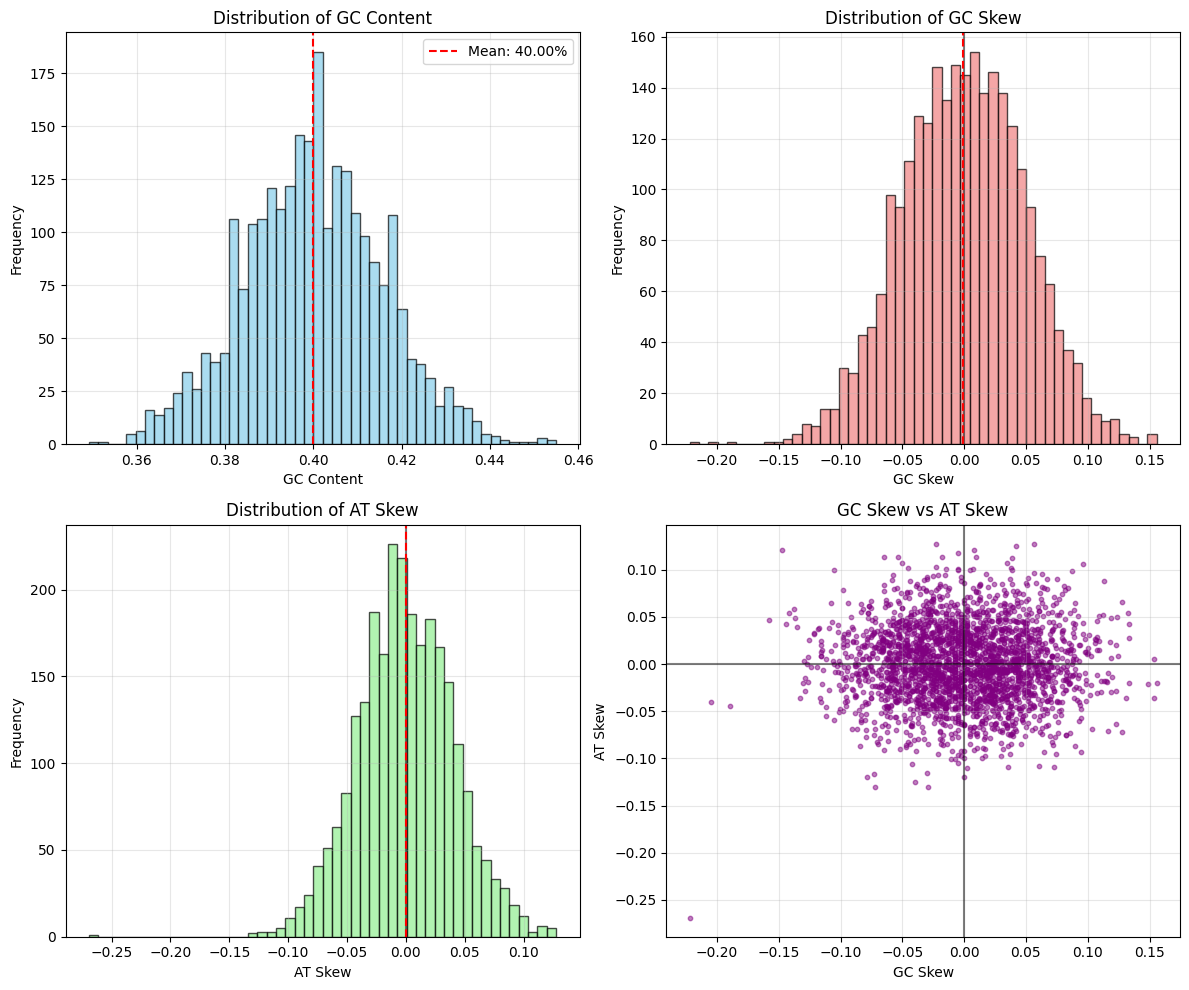

In [6]:
def plot_gc_distribution(composition):
    """
    Vykreslí distribuci GC obsahu.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Histogram GC obsahu
    axes[0, 0].hist(composition['gc_contents'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(np.mean(composition['gc_contents']), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(composition["gc_contents"]):.2%}')
    axes[0, 0].set_xlabel('GC Content')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of GC Content')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # GC skew distribuce
    axes[0, 1].hist(composition['gc_skews'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].axvline(0, color='black', linestyle='-', alpha=0.5)
    axes[0, 1].axvline(np.mean(composition['gc_skews']), color='red', linestyle='--')
    axes[0, 1].set_xlabel('GC Skew')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of GC Skew')
    axes[0, 1].grid(True, alpha=0.3)
    
    # AT skew distribuce
    axes[1, 0].hist(composition['at_skews'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 0].axvline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].axvline(np.mean(composition['at_skews']), color='red', linestyle='--')
    axes[1, 0].set_xlabel('AT Skew')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of AT Skew')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Korelace GC a AT skew
    axes[1, 1].scatter(composition['gc_skews'], composition['at_skews'], 
                       alpha=0.5, s=10, color='purple')
    axes[1, 1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 1].axvline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 1].set_xlabel('GC Skew')
    axes[1, 1].set_ylabel('AT Skew')
    axes[1, 1].set_title('GC Skew vs AT Skew')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('gc_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

# Vykreslení
plot_gc_distribution(composition)

# Úkol 4.2: Scaffoldová statistika

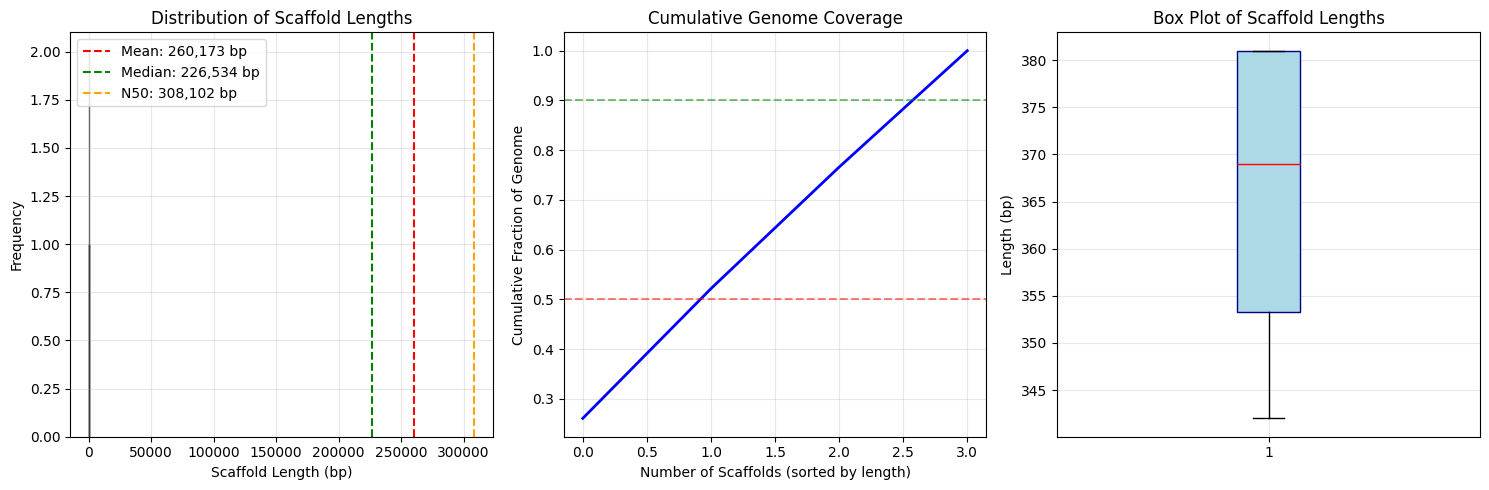

In [7]:
def plot_scaffold_statistics(lengths, stats):
    """
    Vykreslí statistiky scaffoldů.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Histogram délek scaffoldů
    axes[0].hist(lengths, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].axvline(stats['mean_length'], color='red', linestyle='--', 
                    label=f'Mean: {stats["mean_length"]:,.0f} bp')
    axes[0].axvline(stats['median_length'], color='green', linestyle='--',
                    label=f'Median: {stats["median_length"]:,.0f} bp')
    axes[0].axvline(stats['N50'], color='orange', linestyle='--',
                    label=f'N50: {stats["N50"]:,.0f} bp')
    axes[0].set_xlabel('Scaffold Length (bp)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Scaffold Lengths')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Kumulativní distribuce
    sorted_lengths = np.sort(lengths)[::-1]
    cumulative = np.cumsum(sorted_lengths)
    total = np.sum(lengths)
    
    axes[1].plot(cumulative / total, 'b-', linewidth=2)
    axes[1].axhline(0.5, color='red', linestyle='--', alpha=0.5)
    axes[1].axhline(0.9, color='green', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Number of Scaffolds (sorted by length)')
    axes[1].set_ylabel('Cumulative Fraction of Genome')
    axes[1].set_title('Cumulative Genome Coverage')
    axes[1].grid(True, alpha=0.3)
    
    # Box plot
    axes[2].boxplot(lengths, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='darkblue'),
                   medianprops=dict(color='red'))
    axes[2].set_ylabel('Length (bp)')
    axes[2].set_title('Box Plot of Scaffold Lengths')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('scaffold_stats.png', dpi=150, bbox_inches='tight')
    plt.show()

# Vykreslení
plot_scaffold_statistics(lengths, stats)

# Část 5: Pokročilá analýza - detekce horizontálního transferu genů
# Úkol 5.1: Analýza kodonového užití

In [8]:
def codon_adaptation_index(sequence, reference_table=None):
    """
    Vypočítá Codon Adaptation Index (CAI).
    """
    if reference_table is None:
        # Referenční tabulka pro hlavonožce (zjednodušená)
        reference_table = {
            'AAA': 0.22, 'AAC': 0.31, 'AAG': 0.78, 'AAT': 0.69,
            'ACA': 0.17, 'ACC': 0.36, 'ACG': 0.11, 'ACT': 0.36,
            'AGA': 0.11, 'AGC': 0.24, 'AGG': 0.21, 'AGT': 0.15,
            'ATA': 0.16, 'ATC': 0.46, 'ATG': 1.00, 'ATT': 0.38,
            'CAA': 0.34, 'CAC': 0.41, 'CAG': 0.66, 'CAT': 0.59,
            'CCA': 0.27, 'CCC': 0.33, 'CCG': 0.11, 'CCT': 0.29,
            'CGA': 0.06, 'CGC': 0.19, 'CGG': 0.21, 'CGT': 0.11,
            'CTA': 0.07, 'CTC': 0.20, 'CTG': 0.41, 'CTT': 0.13,
            'GAA': 0.47, 'GAC': 0.43, 'GAG': 0.53, 'GAT': 0.57,
            'GCA': 0.23, 'GCC': 0.40, 'GCG': 0.11, 'GCT': 0.26,
            'GGA': 0.25, 'GGC': 0.34, 'GGG': 0.16, 'GGT': 0.25,
            'GTA': 0.11, 'GTC': 0.24, 'GTG': 0.47, 'GTT': 0.18,
            'TAA': 1.00, 'TAC': 0.44, 'TAG': 1.00, 'TAT': 0.56,
            'TCA': 0.15, 'TCC': 0.22, 'TCG': 0.06, 'TCT': 0.17,
            'TGA': 1.00, 'TGC': 0.41, 'TGG': 1.00, 'TGT': 0.59,
            'TTA': 0.14, 'TTC': 0.42, 'TTG': 0.13, 'TTT': 0.58,
        }
    
    # Najdi všechny ORFy
    orfs = find_orf(sequence, min_length=300)
    
    if not orfs:
        return 0
    
    cai_values = []
    
    for orf in orfs:
        orf_seq = orf['sequence']
        codon_scores = []
        
        # Projdi ORF po kodonech
        for i in range(0, len(orf_seq) - 2, 3):
            codon = orf_seq[i:i+3].upper()
            if codon in reference_table:
                codon_scores.append(reference_table[codon])
        
        if codon_scores:
            # CAI = geometrický průměr
            log_scores = np.log(codon_scores)
            cai = np.exp(np.mean(log_scores))
            cai_values.append(cai)
    
    return np.array(cai_values) if cai_values else np.array([0])

# Výpočet CAI
cai_values = codon_adaptation_index(test_scaffold)
print(f"\n=== Codon Adaptation Index ===")
print(f"Počet analyzovaných ORFů: {len(cai_values)}")
if len(cai_values) > 0:
    print(f"CAI: min={cai_values.min():.3f}, max={cai_values.max():.3f}, mean={cai_values.mean():.3f}")
    
    # Identifikace potenciálních horizontálně transferovaných genů
    threshold = np.percentile(cai_values, 25)  # Spodní kvartil
    potential_htg = cai_values[cai_values < threshold]
    print(f"Potenciální horizontálně transferované geny (CAI < {threshold:.3f}): {len(potential_htg)}")


=== Codon Adaptation Index ===
Počet analyzovaných ORFů: 4
CAI: min=0.264, max=0.286, mean=0.276
Potenciální horizontálně transferované geny (CAI < 0.268): 1


# Bonusová část: Machine learning klasifikace
# Úkol B.1: Klasifikace kódovacích vs nekódovacích oblastí

In [9]:
def extract_features(sequence, window_size=60):
    """
    Extrahuje features z DNA sekvence pro ML.
    """
    features = []
    
    for i in range(0, len(sequence) - window_size + 1, window_size):
        window = sequence[i:i+window_size].upper()
        
        if len(window) < window_size:
            break
        
        # 1. GC obsah
        gc_content = (window.count('G') + window.count('C')) / len(window)
        
        # 2. AT a GC skew
        a, c, g, t = (window.count(base) for base in ['A', 'C', 'G', 'T'])
        at_skew = (a - t) / (a + t) if (a + t) > 0 else 0
        gc_skew = (g - c) / (g + c) if (g + c) > 0 else 0
        
        # 3. Dinukleotidové frekvence (vybrané)
        aa_freq = window.count('AA') / (len(window) - 1)
        cc_freq = window.count('CC') / (len(window) - 1)
        gg_freq = window.count('GG') / (len(window) - 1)
        tt_freq = window.count('TT') / (len(window) - 1)
        
        # 4. Entropie
        from collections import Counter
        base_counts = Counter(window)
        total = sum(base_counts.values())
        entropy = -sum((count/total) * np.log2(count/total) 
                      for count in base_counts.values() if count > 0)
        
        features.append([
            gc_content, at_skew, gc_skew,
            aa_freq, cc_freq, gg_freq, tt_freq,
            entropy, len(window)
        ])
    
    return np.array(features)

# Test extrakce features
features = extract_features(test_scaffold[:5000])
print(f"\n=== ML Features Extraction ===")
print(f"Počet oken: {features.shape[0]}")
print(f"Počet features: {features.shape[1]}")
print(f"Prvních 5 oken:\n{features[:5]}")


=== ML Features Extraction ===
Počet oken: 83
Počet features: 9
Prvních 5 oken:
[[ 4.33333333e-01  5.88235294e-02  0.00000000e+00  5.08474576e-02
   3.38983051e-02  5.08474576e-02  5.08474576e-02  1.98572255e+00
   6.00000000e+01]
 [ 4.33333333e-01  1.17647059e-01  2.30769231e-01  8.47457627e-02
   1.69491525e-02  8.47457627e-02  5.08474576e-02  1.96466955e+00
   6.00000000e+01]
 [ 4.66666667e-01  1.87500000e-01  0.00000000e+00  5.08474576e-02
   1.69491525e-02  5.08474576e-02  3.38983051e-02  1.98318598e+00
   6.00000000e+01]
 [ 4.16666667e-01 -2.57142857e-01  4.00000000e-02  5.08474576e-02
   3.38983051e-02  6.77966102e-02  1.01694915e-01  1.95124929e+00
   6.00000000e+01]
 [ 4.00000000e-01  1.66666667e-01 -2.50000000e-01  1.01694915e-01
   1.69491525e-02  1.69491525e-02  5.08474576e-02  1.94064545e+00
   6.00000000e+01]]


# Závěrečná zpráva - Co odevzdat:
1. Kód s implementovanými funkcemi

2. Grafy:

- Distribuce GC obsahu

- Statistiky scaffoldů

- Porovnání s jinými organismy

3. Statistický souhrn:

- Základní statistiky genomu

- Analýza ORFů

- Potenciální horizontálně transferované geny

4. Závěr: Co jste se dozvěděli o genomu hlavonožce?